In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import sys

module_path = os.path.abspath(
    os.path.join(
        "/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

In [15]:
# Qiskit imports
from qiskit import pulse, transpile
from qiskit.transpiler import InstructionDurations, InstructionProperties
from qiskit.circuit import (
    ParameterVector,
    QuantumCircuit,
    QuantumRegister,
    Gate,
    CircuitInstruction,
    Parameter,
)
from qiskit.circuit.library import get_standard_gate_name_mapping

from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta, FakeJakartaV2
from qiskit_dynamics import DynamicsBackend, Solver
from qiskit_experiments.calibration_management import Calibrations
from qiskit_experiments.library import RoughXSXAmplitudeCal, RoughDragCal
from qiskit_experiments.calibration_management.basis_gate_library import (
    FixedFrequencyTransmon,
    EchoedCrossResonance,
)
from helper_functions import perform_standard_calibrations
from itertools import permutations
import numpy as np
import tqdm
import time
from typing import Union, Optional, List, Sequence, Dict
from IPython.display import clear_output
import jax

jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
# import Array and set default backend
from qiskit_dynamics.array import Array

Array.set_default_backend("jax")
pulse.SymbolicPulse.disable_validation = True

In [16]:
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver, Signal

dim = 2
dt = 1 / 4.5e9
v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

X = Operator.from_label("X")
Z = Operator.from_label("Z")

solver = Solver(
    static_hamiltonian=0.5 * 2 * np.pi * v0 * Z,
    hamiltonian_operators=[2 * np.pi * r0 * X],
    rotating_frame=0.5 * 2 * np.pi * v0 * Z,
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": v0},
    dt=dt,
    evaluation_mode="dense",
)

In [17]:
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim],  # for computing measurement data
    solver_options=solver_options,  # to be used every time run is called
)
cals, exp_results = perform_standard_calibrations(backend)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'x', 't', 'h', 'delay', 's', 'measure', 'tdg', 'z', 'sdg', 'reset', 'sx', 'id', 'rz'}
Multi qubit instructions:
)>


In [18]:
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector

y0 = Array(Statevector(np.array([1.0, 0.0])))
dt = 2.222e-10
rtol = 1e-8
atol = 1e-6
phase_params = ParameterVector("phase", 3)
h_sched = backend.target.get_calibration("h", (0,))
x_sched = backend.target.get_calibration("x", (0,))
meas_sched = backend.target.get_calibration("measure", (0,))
# build a pulse schedule
with pulse.build(default_alignment="sequential") as sched_ext:
    # pulse.call(x_sched)
    pulse.call(h_sched)
    pulse.shift_phase(phase_params[0], pulse.DriveChannel(0))
    pulse.call(h_sched)

t_linspace = np.linspace(0.0, sched_ext.duration * dt, 100)
print(sched_ext.duration)

320


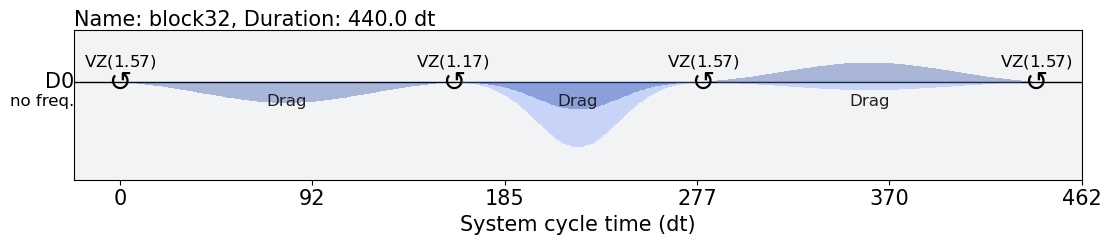

In [19]:
def my_sched():
    with pulse.build(default_alignment="sequential") as sched_ext:
        # pulse.call(x_sched)
        pulse.call(h_sched)
        pulse.shift_phase(phase_params[0], pulse.DriveChannel(0))
        pulse.shift_phase(phase_params[1], pulse.DriveChannel(0))
        pulse.shift_phase(phase_params[2], pulse.DriveChannel(0))
        pulse.play(
            pulse.Drag(
                amp=phase_params[2], duration=120, sigma=20, angle=0.0, beta=0.0
            ),
            pulse.DriveChannel(0),
        )
        pulse.call(h_sched)
    return sched_ext


def my_clean_sched(param):
    with pulse.build(default_alignment="sequential") as sched_ext:
        # pulse.call(x_sched)
        pulse.call(h_sched)
        pulse.shift_phase(0.4, pulse.DriveChannel(0))
        pulse.play(
            pulse.Drag(amp=param, duration=120, sigma=20, angle=0.0, beta=0.0),
            pulse.DriveChannel(0),
        )
        pulse.call(h_sched)
    return sched_ext


my_clean_sched(0.2).draw()

In [23]:
# Inside jit function method
import jax.numpy as jnp
from jax import block_until_ready, vmap
from qiskit_dynamics.array import wrap

jit = wrap(jax.jit, decorator=True)
qd_vmap = wrap(vmap, decorator=True)


def get_sched(phases):
    # sched_in = my_sched().assign_parameters({param:phase for (param, phase) in zip(phase_params, phases)}, inplace = False)
    with pulse.build(default_alignment="sequential") as sched_in:
        # pulse.call(x_sched)
        # pulse.call(h_sched)
        # pulse.shift_phase(0.4, pulse.DriveChannel(0))
        pulse.play(
            pulse.Drag(amp=0.2, duration=160, sigma=phases[0], angle=0.0, beta=0.0),
            pulse.DriveChannel(0),
        )
        # pulse.call(h_sched)

    t_linspace = jnp.linspace(0, sched_in.duration * dt, 20)
    results = solver.solve(
        t_span=[t_linspace[0], t_linspace[-1]],
        y0=y0,
        signals=sched_in,
        # signals=sched,
        # t_eval=t_linspace[-1],
        **solver_options
    )

    return results.y


sched_fast = jit(get_sched)

In [24]:
# sched_fast([np.pi, np.pi/2, 0.3])
sched_fast(jnp.array([0.2]))

Array([[1.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j],
       [9.99996231e-01-3.56759183e-08j, 1.35869146e-04-2.75324712e-03j]])

In [26]:
param = Parameter("theta")
with pulse.build(default_alignment="sequential") as sched:
    # pulse.call(x_sched)
    # pulse.call(h_sched)
    pulse.play(
        pulse.Drag(amp=0.2, duration=120, sigma=20, beta=0, angle=param),
        pulse.DriveChannel(0),
    )
s = jnp.float64(0.2)

In [29]:
sched.instructions[0][1].pulse.disable_validation

True

In [ ]:
import sympy2jax
import sympy
import jax.numpy as jnp

x_sym = sympy.symbols("x_sym")
y_sym = sympy.symbols("y_sym")
cosx = 1.0 * sympy.cos(x_sym) + 1.0 * sympy.cos(y_sym)
sinx = 2.0 * sympy.sin(x_sym) + 2.0 * sympy.sin(y_sym)
mod = sympy2jax.SymbolicModule([cosx, sinx])  # PyTree of input expressions
type(cosx)
info = {x_sym.name: x, y_sym.name: y}

In [ ]:
x_sym.name

In [ ]:
x = jnp.zeros(3)
y = jnp.ones(3)
out = mod(**info)
out

In [ ]:
param = Parameter("amp")
param2 = Parameter("amp2")
param3 = 2 * param
param3._parameter_symbols
type(param3._symbol_expr)
param4 = sympy.sympify(param3._symbol_expr)
type(param4)

In [ ]:
for key, value in param2._parameter_symbols.items():
    print(type(key), type(value))

/Users/arthurstrauss/opt/anaconda3/envs/rl_qoc/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


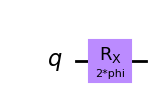

In [30]:
qc = QuantumCircuit(1)
phi = Parameter("phi")
qc.rx(2 * phi, 0)
qc.draw("mpl")

/var/folders/bv/rc7ck74566l1hj1z9mc63ps40000gn/T/ipykernel_50088/3226416432.py:1: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc.bind_parameters([0.5]).draw("mpl")


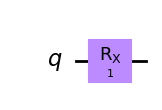

In [31]:
qc.bind_parameters([0.5]).draw("mpl")

In [ ]:
x_pulse = backend.target.get_calibration("x", (0,)).instructions[0][1].pulse
x_pulse

In [ ]:
setattr(x_pulse, "amp", 0.3)
x_pulse

In [23]:
# Constructing General Gaussian Waveform


# Helper function that returns a lifted Gaussian symbolic equation.
def lifted_gaussian(
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    return (gauss - offset) / (1 - offset)

In [28]:
# use amplitude as the function argument
from qiskit import pulse
from qiskit_dynamics.pulse import InstructionToSignals
import sympy as sym

dt = 0.222
w = 5.0


def jit_func(amp):
    _t, _duration, _amp, _sigma, _angle = sym.symbols("t, duration, amp, sigma, angle")
    _center = _duration / 2

    envelope_expr = (
        _amp
        * sym.exp(sym.I * _angle)
        * lifted_gaussian(_t, _center, _duration + 1, _sigma)
    )

    gaussian_pulse = pulse.ScalableSymbolicPulse(
        pulse_type="Gaussian",
        duration=160,
        amp=amp,
        angle=0,
        parameters={"sigma": 40},
        envelope=envelope_expr,
        constraints=_sigma > 0,
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )
    drag_pulse = pulse.Drag(duration=160, amp=amp, sigma=20, angle=0, beta=0)

    # build a pulse schedule
    with pulse.build() as schedule:
        # pulse.play(gaussian_pulse, pulse.DriveChannel(0))
        pulse.play(drag_pulse, pulse.DriveChannel(0))
    # convert from a pulse schedule to a list of signals
    converter = InstructionToSignals(dt, carriers={"d0": w})

    return converter.get_signals(schedule)[0].samples.data


jax.jit(jit_func)(0.4)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[].
The error occurred while tracing the function jit_func at /var/folders/82/30qkl1t503n87c1769x88frm0000gp/T/ipykernel_5140/1795574498.py:7 for jit. This concrete value was not available in Python because it depends on the value of the argument amp.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError